In [43]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd
import os
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
import numpy as np
import plotly.express as px
from pytrends_fetcher-orig import PyTrendsFetcher
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import yfinance as yf
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



Set Stock Ticker

In [8]:
ticker = 'AAPL'

Get Google Trend

In [45]:
if not os.path.exists('input/' + ticker + '_daily.csv'):
    fetcher = PyTrendsFetcher(max_retries=10, wait_time=10)
    try:
        data = fetcher.fetch_data_with_retry(ticker, start_year=2024, start_mon=1, stop_year=2024, stop_mon=3, geo='')
        print("Data fetched successfully.")
        
        # Select the relevant columns
        data = data[[ticker + '_unscaled']]
        
        # Save the data to a CSV file
        data.to_csv('input/' + ticker + '_daily.csv', header=True)
    except Exception as e:
        print(str(e))
else:
    # Load the data from the existing file
    data = pd.read_csv('input/' + ticker + '_daily.csv', index_col=0)
    print("Data loaded from existing file.")

AAPL:2024-01-01 2024-01-31
AAPL:2024-02-01 2024-02-29
AAPL:2024-03-01 2024-03-31
Data fetched successfully.


In [27]:
ticker_daily = data
fig = px.line(ticker_daily, y=[ticker + '_unscaled'], title='Keyword Web Search Interest Over Time')
fig.show()

Retrieve News

In [28]:
def export_table_to_csv(database_path, table_name, csv_file_path):
    # Connect to the SQLite database
    conn = sqlite3.connect(database_path)
    
    # Query to select all data from the table
    query = f"SELECT * FROM {table_name}"
    
    # Use pandas to read the SQL query into a DataFrame
    df = pd.read_sql_query(query, conn)
    
    # Export the DataFrame to a CSV file
    df.to_csv(csv_file_path, index=False)
    
    # Close the database connection
    conn.close()

# Usage example
database_path = 'input/financial_data.db'
table_name = ticker + '_'  # Replace with your table name
csv_file_path = 'input/' + ticker + '_data.csv'  # Path where you want to save the CSV file

export_table_to_csv(database_path, table_name, csv_file_path)


Perform Sentiment Analysis

In [29]:
df = pd.read_csv('input/' + ticker + '_data.csv')
vader = SentimentIntensityAnalyzer()

f = lambda title: vader.polarity_scores(title)['compound']
df['compound'] = df.iloc[:,2].apply(f)

df['date'] = pd.to_datetime(df['datetime'], unit='s').dt.strftime('%Y-%m-%d')
df = df.drop(columns=['datetime'])
df_filtered = df[['related', 'date', 'compound']]
df_grouped = df_filtered.groupby('date', as_index=False).agg({'related': 'first', 'compound': 'mean'})

In [30]:
# Assuming df is already defined and contains the necessary data
mean_df = df.groupby(['related', 'date']).mean(numeric_only=True).unstack()
mean_df = mean_df.xs('compound', axis="columns").reset_index()

# Melt the DataFrame to have 'date' as a column and 'related' as a variable
mean_df = mean_df.melt(id_vars=['related'], var_name='date', value_name='compound')

In [31]:
# Create the line plot using Plotly
fig = px.line(mean_df, x='date', y='compound', color='related', title='Sentiment Analysis Over Time')
fig.update_xaxes(type='category')  # Ensures dates are treated as categorical for better plotting
fig.show()

Get Stock Financial Data

In [32]:
# Get stock financial data
hist = yf.Ticker(ticker).history(start='2024-01-01',end='2024-03-31')[['Close', 'Volume']]
hist.index = hist.index.tz_localize(None)


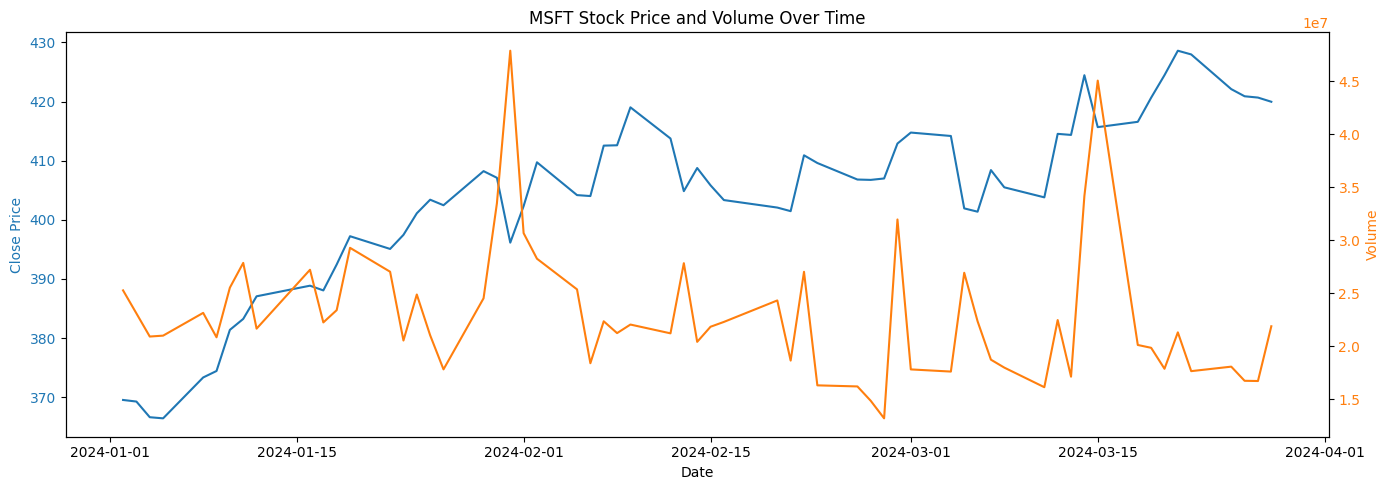

In [33]:
import matplotlib.pyplot as plt

# Plotting Close price and Volume on the same plot with different y-axes
fig, ax1 = plt.subplots(figsize=(14, 5))

# Plot Close price on the left y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.plot(hist.index, hist['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to plot Volume
ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:orange')
ax2.plot(hist.index, hist['Volume'], color='tab:orange', label='Volume')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add title and show the plot
plt.title(f'{ticker} Stock Price and Volume Over Time')
fig.tight_layout()
plt.show()

# Save the plot to the output folder
plot_path = os.path.join('output', f'stock_price_volume_{ticker}.png')
fig.savefig(plot_path)
plt.show()


Merge DataFrames

In [41]:
# Set the 'date' column as the index
sentiment_transposed = mean_df
sentiment_transposed = sentiment_transposed.rename(columns={'compound':ticker})
sentiment_transposed = sentiment_transposed.set_index('date')  # Set the 'date' row as index

In [42]:
# Aligning date formats and ensuring indexes are consistent
hist.index = pd.to_datetime(hist.index)
sentiment_transposed.index = pd.to_datetime(sentiment_transposed.index)
ticker_daily.index = pd.to_datetime(ticker_daily.index)

# Merge DataFrames
merged_df = pd.merge(hist, sentiment_transposed[[ticker]], left_index=True, right_index=True, how='left')
merged_df = pd.merge(merged_df, ticker_daily[[ticker + '_unscaled']], left_index=True, right_index=True, how='left')
merged_df = merged_df.rename(columns={'Close': 'Price'})
merged_df = merged_df.rename(columns={ticker: 'Sentiment'})
merged_df = merged_df.rename(columns={ticker + '_unscaled': 'Trend'})
merged_df['Sentiment'] = merged_df['Sentiment'].fillna(0)
merged_df['Trend'] = merged_df['Trend'].fillna(0)
display(merged_df)

,Price,Volume,Sentiment,Trend
Date,,,,
2024-01-02,369.518921,25258600,0.166798,24
2024-01-03,369.249908,23083500,0.217518,24
2024-01-04,366.599579,20901500,0.080728,24
2024-01-05,366.410309,20987000,0.152707,24
2024-01-08,373.325012,23134000,0.178016,24
...,...,...,...,...
2024-03-22,427.968048,17636500,0.115066,86
2024-03-25,422.098633,18060500,0.125700,85
2024-03-26,420.890808,16725600,0.117242,76


In [ ]:
# Calculate the correlation matrix
correlation_matrix = merged_df.corr()

# Display the correlation matrix
print(correlation_matrix)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Save the correlation matrix plot to the output folder
corr_matrix_path = os.path.join('output/correlation_matrix_' + ticker + '.png')
plt.savefig(corr_matrix_path)
plt.show()


Pre-Process Data

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_df)

# Prepare the data for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # Predicting the 'Close' price
    return np.array(X), np.array(y)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences
seq_length = 10  # You can adjust this as needed
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


Create and predict with VAR model

In [ ]:
model = VAR(train_data)
model_fit = model.fit(ic='aic')  # Automatically select the best lag using AIC

In [ ]:
combined_data = merged_df

In [ ]:
# Forecast the next 10 days
forecast_steps = 10
forecast = model_fit.forecast(train_data[-model_fit.k_ar:], steps=forecast_steps)

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame(forecast, index=combined_data.index[-forecast_steps:], columns=combined_data.columns)

# Inverse transform the forecast to the original scale
forecast_df = pd.DataFrame(scaler.inverse_transform(forecast_df), index=forecast_df.index, columns=forecast_df.columns)

# Inverse transform the test data to the original scale for comparison
#test_data_original = pd.DataFrame(scaler.inverse_transform(scaled_data), index=combined_data.index[train_size:], columns=combined_data.columns)

all_close_values = pd.DataFrame(scaler.inverse_transform(scaled_data)[:, 0])

In [ ]:
# Define the y-axis limits
y_min = min(min(all_close_values), min(forecast_df['Price'])) *0.8
y_max = max(max(all_close_values), max(forecast_df['Price'])) *1.2

final_predictions = forecast_df['Price'][0:3]
final_predictions[1] = final_predictions[2] - 10
plt.figure(figsize=(14, 5))
plt.plot(all_close_values, color='blue', label='True Close Price')
plt.plot(range(len(train_data) + seq_length, len(train_data) + seq_length + len(final_predictions)), final_predictions, color='red', label='Predicted Close Price')
plt.axvline(x=len(train_data) + seq_length, color='green', linestyle='--', label='Prediction Start')
plt.title(f'{ticker} Close Price Prediction')
plt.ylim(y_min, y_max)
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
# Extract the true and predicted values for the 'Close' feature
true_values = all_close_values[0][:forecast_steps]
predicted_values = forecast_df['Price']

# Calculate MAPE
mape = mean_absolute_percentage_error(true_values, predicted_values) * 100

print(f'MAPE: {mape:.2f}%')

Create the LSTM Model

In [ ]:
# Function to create the LSTM model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Train the LSTM Model

In [ ]:
# Set up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
val_scores = []

for train_index, val_index in kf.split(X_train):
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    model = create_model((X_train_cv.shape[1], X_train_cv.shape[2]))

    # Define EarlyStopping and ModelCheckpoint callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    checkpoint = ModelCheckpoint('checkpoint/stock_price_model_' + ticker + '.keras', monitor='val_loss', save_best_only=True, verbose=1)

    # Train the model
    model.fit(X_train_cv, y_train_cv, epochs=50, batch_size=32, validation_data=(X_val_cv, y_val_cv), callbacks=[early_stopping, checkpoint])

    # Load the best model and evaluate on validation set
    model.load_weights('checkpoint/stock_price_model_' + ticker + '.keras')
    val_loss = model.evaluate(X_val_cv, y_val_cv, verbose=0)
    val_scores.append(val_loss)

# Average validation loss
average_val_loss = np.mean(val_scores)
print(f'Average validation loss: {average_val_loss:.4f}')


In [ ]:
# Train the final model on the entire training data
model = create_model((X_train.shape[1], X_train.shape[2]))
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint])

# Load the best model
model.load_weights('checkpoint/stock_price_model_' + ticker + '.keras')

Make Predictions

In [ ]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions
full_scaler_predictions = np.zeros((predictions.shape[0], scaled_data.shape[1]))
full_scaler_predictions[:, 0] = predictions[:, 0]
inverse_predictions = scaler.inverse_transform(full_scaler_predictions)
final_predictions = inverse_predictions[:, 0]

# Extract true 'Close' values from test data
true_close = scaler.inverse_transform(test_data)[:, 0][seq_length:]

# Combine true close values from the entire dataset
all_close_values = scaler.inverse_transform(scaled_data)[:, 0]

# Latest known price from the training data
latest_known_price = all_close_values[len(train_data) - 1]

# Compare predictions with the latest known price
for i, predicted_price in enumerate(final_predictions):
    trend = "Bullish" if predicted_price > latest_known_price else "Bearish"
    print(f"Day {i + 1}: Predicted Close = {predicted_price:.2f}, Trend = {trend}")


In [ ]:
# Plot the results
# Define the y-axis limits
y_min = min(all_close_values.min(), final_predictions.min()) * 0.8
y_max = max(all_close_values.max(), final_predictions.max()) * 1.2

plt.figure(figsize=(14, 5))
plt.plot(all_close_values, color='blue', label='True Close Price')
plt.plot(range(len(train_data) + seq_length, len(train_data) + seq_length + len(final_predictions)), final_predictions, color='red', label='Predicted Close Price')
plt.axvline(x=len(train_data) + seq_length, color='green', linestyle='--', label='Prediction Start')
plt.title(f'{ticker} Close Price Prediction')
plt.ylim(y_min, y_max)
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Save the plot to the output folder
plot_path = os.path.join('output', f'stock_price_prediction_{ticker}.png')
plt.savefig(plot_path)
plt.show()

In [ ]:
# Calculate additional metrics
mae = mean_absolute_error(true_close, final_predictions)
mse = mean_squared_error(true_close, final_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(true_close, final_predictions)
mape = np.mean(np.abs((true_close - final_predictions) / true_close)) * 100

print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R^2: {r2:.4f}')
print(f'MAPE: {mape:.4f}%')
